In [39]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# we assumed that 2 dimensional shape

In [40]:
type(None) == type(None)

True

In [41]:
# variable holder 
class Variable():

    def __init__(self,inputShapes,data = None,requires_grad = True,step_size = 1):
        # keep the step size to be scalar
        self.shape = inputShapes
        self.requires_grad = True
        self.data = data
        if type(self.data) == type(None):
            self.value = np.random.rand(*self.shape) # 2d vector
        else:
            self.value = data
        self.step_size = step_size

    def forward(self):
        return self.value

    def backward(self,value):
        # print("Variable  " , value.shape)
        # print("Original " , self.value.shape)
        self.value -= self.step_size * value
        pass

In [42]:
class MatrixMul():

    def __init__(self):
        pass 

    def __call__(self):
        pass 

    def forward(self,matrixA, matrixB):
        # matrixA is of Variable type
        # matrixB is of variable type
        # self.value is always numpy array in all the classes
        self.matrixA = matrixA
        self.matrixB = matrixB
        # print("This is the matrix A : ",matrixA.value.shape)
        # print("This is the matrix B : ",matrixB.value.shape)
        self.value = self.matrixA.value @ self.matrixB.value

        return self.value

    def backward(self,value):
        # value # matrix
        # print("This is MatrixMul : " , value.shape)
        self.result1 = value @ self.matrixB.value.T # this will be passed to A
        self.result2 = self.matrixA.value.T @ value # this will be passed to B
        self.matrixA.backward(self.result1)
        self.matrixB.backward(self.result2)

        # a * b = c
        # dl/dc = matrix
        # dl/da = dl/dc . dc/da

In [43]:
class ReLU():

    def __init__(self):
        pass

    def forward(self,prevOperation):
        # lastOperation  will be the object of matrix mul
        self.prevOperation = prevOperation
        self.value = np.where(self.prevOperation.value < 0,0,self.prevOperation.value)
        # self.value values will be positive
        return self.value

    def backward(self,value):
        # print("This is ReLU : ",value.shape)
        temp = np.ones(self.value.shape)
        temp = np.where(self.value<=0,0,temp)
        self.result = temp * value
        self.prevOperation.backward(self.result)

In [44]:
class RegressionLoss():

    def __init__(self):
        pass

    def forward(self,original,predicted):
        self.original = original
        self.predicted = predicted
        self.value = np.sum((self.original.value-self.predicted.value) ** 2) * 0.5
        return self.value

    def __call__(self):
        pass

    def backward(self,value):
        ## Each of this functions should call the backward function of it's calle variables.
        ## scalar value times
        ## [[1]]  1* 1

        # print("This is the Regression : ", value.shape )
        self.dldy = (self.predicted.value - self.original.value) * value
        # print("this is point" , self.dldy)
        # print("This should be of type add ", type(self.predicted))
        self.predicted.backward(self.dldy)

In [45]:
class Add():
    def __init__(self):
        pass

    def forward(self, f_input1, f_input2):
        self.f_input1 = f_input1
        self.f_input2 = f_input2
        self.value = f_input1.value + f_input2.value
        return self.value

    def backward(self, b_grad):
        # print("This is the Addition : ",b_grad.shape)
        self.grad = b_grad * np.ones(self.value.shape)

        self.f_input2.backward(self.grad)
        self.f_input1.backward(self.grad)

        # self.grad = b_grad * 1 #Addition
        return self.grad

In [46]:
# for bias
class Bias(Variable):

     def backward(self,value):
         self.update = np.sum(value,axis = 0)
         self.value -= self.update * self.step_size
         pass

In [47]:
# optional if needed 
class Linear():
    def __init__(self,weight, bias,activation_function = False):
        # weight and bias should be of type Variable
        # activation_function True means we are using ReLU
        self.weight = weight
        self.bias = bias
        self.addition = Add()
        self.matmul = MatrixMul()
        self.activation_function = activation_function
        if(self.activation_function):
            self.activation = ReLU()

    def forward(self,x):
        self.input = x
        self.value = self.matmul.forward(x,self.weight)
        self.value = self.addition.forward(self.matmul,self.bias)
        self.finalOperation = self.addition
        if(self.activation_function):
            self.value = self.activation.forward(self.addition)
            self.finalOperation = self.activation
        return self.finalOperation

    def backward(self,grad):
        # print("This is linear Linear : ", grad.shape)
        if self.activation_function:
            self.activation.backward(grad)
        else:
            self.addition.backward(grad)

In [48]:
def dataloader():
    with open('assignment-one-test-parameters.pkl','rb') as f:
        data = pickle.load(f)
    inputs = data["inputs"]
    w1 = data["w1"]
    w2 = data["w2"]
    w3 = data["w3"]
    b1 = data["b1"]
    b2 = data["b2"]
    b3 = data["b3"]
    targets = np.reshape(data["targets"],(data["targets"].shape[0],1))
    params = {
        "w1" : w1.T,
        "w2" : w2.T,
        "w3" : w3.T,
        "b1" : np.reshape(b1,(1,b1.shape[0])),
        "b2" : np.reshape(b2,(1,b2.shape[0])),
        "b3" : np.reshape(b3,(1,b3.shape[0])),
    }
    trainset = (inputs, targets)

    return trainset, params


In [49]:
trainset,params  = dataloader()

In [50]:
trainset[0].shape

(200, 2)

In [51]:
step_size = 0.0001
w1 = Variable(params["w1"].shape,params["w1"],step_size=step_size)
w2 = Variable(params["w2"].shape,params["w2"],step_size=step_size)
w3 = Variable(params["w3"].shape,params["w3"],step_size=step_size)
b1 = Bias(params["b1"].shape,params["b1"],step_size=step_size)
b2 = Bias(params["b2"].shape,params["b2"],step_size=step_size)
b3 = Bias(params["b3"].shape,params["b3"],step_size=step_size)

In [52]:
print("w1 shape : ",w1.value.shape)
print("w2 shape : ",w2.value.shape)
print("w3 shape : ",w3.value.shape)

w1 shape :  (2, 10)
w2 shape :  (10, 10)
w3 shape :  (10, 1)


In [53]:
w1.shape

(2, 10)

In [54]:
b1.shape

(1, 10)

In [55]:
## Linear layers
Linear1 = Linear(w1,b1,True)
Linear2 = Linear(w2,b2,True)
Linear3 = Linear(w3,b3,False)
x = Variable(trainset[0].shape,trainset[0])

y = Linear1.forward(x)
y = Linear2.forward(y)
y = Linear3.forward(y)
loss = RegressionLoss()
y_true = Variable(trainset[1].shape,trainset[1])
loss.forward(y_true,y)

107.60015998278625

In [60]:
# training loop
n_epochs = 100
x = Variable(trainset[0].shape,trainset[0])
y_true = Variable(trainset[1].shape,trainset[1])

# Initialize the netword
Linear1 = Linear(w1,b1,True)
Linear2 = Linear(w2,b2,True)
Linear3 = Linear(w3,b3,False)
loss = RegressionLoss()

# bookeeping the losses
losses = []


# run through each of the epochs
for _ in range(n_epochs):

    # forward pass
    y = Linear1.forward(x)
    y = Linear2.forward(y)
    y = Linear3.forward(y)

    loss_value = loss.forward(y_true,y)

    losses.append(loss_value)

    # backward pass
    loss.backward(np.array([[1]]))

In [61]:
losses

[77.74008370140871,
 74.58429526783142,
 71.52559894517609,
 68.17022604624444,
 64.64554170394703,
 61.16667733477844,
 57.73419869895344,
 54.290811294288126,
 50.76773756960145,
 47.19429939256667,
 43.56068810552536,
 39.94596562940679,
 36.474680377708445,
 33.16029893664248,
 30.068185436281613,
 27.23431276582088,
 24.716449772182557,
 22.5228284927709,
 20.638515390395483,
 19.03852976090063,
 17.683187617817076,
 16.53030247136304,
 15.529193151510281,
 14.660907824041155,
 13.892751906847527,
 13.200319031679822,
 12.562874772631787,
 11.966874193524525,
 11.39951087255865,
 10.855484009413777,
 10.33186976986773,
 9.827563387981407,
 9.343834389601726,
 8.875924123408247,
 8.416992413508872,
 7.972989595709398,
 7.547223116034578,
 7.141487405974916,
 6.747161885333977,
 6.364797390644458,
 5.997371522691388,
 5.640535846948373,
 5.300348652906264,
 4.968454298901275,
 4.652999207123871,
 4.350282425817659,
 4.058648627704809,
 3.78389821594103,
 3.515571948662885,
 3.262115

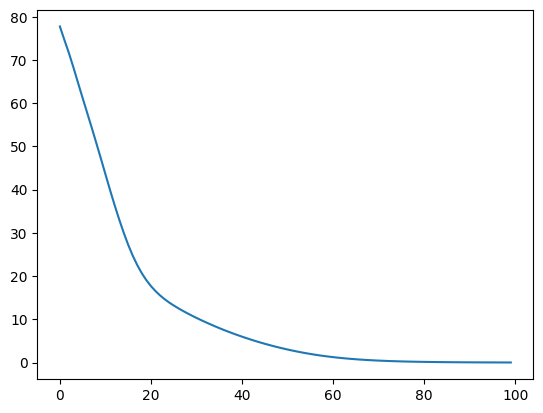

In [62]:
plt.plot(np.arange(len(losses)),losses)

In [37]:
y.value.shape

(200, 1)

In [38]:
loss.backward(np.array([[1]]))
# here the backward pass the shape is (200,1)
# I have just one bias term
# during the backward pass what will be the shape
#

In [58]:
# Initializing variables
A = Variable((10,2)) # assuming here that
# here 10 are the number of examples and 2 are the features
w1 = Variable((2,1)) # the first layer is assumed to be creating the neurons of 5 in size

# Matrix multiplication
h1 = MatrixMul()
res = h1.forward(A,w1) # 10,1

# Computing the ReLU
o1 = ReLU() # 10,1
o1.forward(h1)

# Computing the loss
loss = RegressionLoss()
y = Variable((10,1))
loss.forward(y,o1)

# print(loss.value)

loss.backward(np.array([[1]]))




Reached till Regression loss  [[1]]
this is point [[ 0.5119473 ]
 [ 0.25303018]
 [-0.15150328]
 [ 0.41348196]
 [ 0.2878462 ]
 [-0.24015475]
 [ 0.1195707 ]
 [ 0.20373379]
 [ 0.34159231]
 [ 0.55075722]]
First Gradient  (10, 2)
First Gradient  (2, 1)
[[ 0.5119473 ]
 [ 0.25303018]
 [-0.15150328]
 [ 0.41348196]
 [ 0.2878462 ]
 [-0.24015475]
 [ 0.1195707 ]
 [ 0.20373379]
 [ 0.34159231]
 [ 0.55075722]]


In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return (x > 0).astype(float)

In [ ]:
### Goal 
# feel free to change the structure as you the need be
# This are just my initial thoughts 
# A = varialbe(n,m)
# w1 = variable(n,m)
# h1 = Matmul(A,w1)
# o1 = ReLu(h1)
# w2 = variable(n,m)
# h2 = Matmul(o1,w2)
# w3 = variable(n,m)
# loss = RegLoss(Matmul(h2,w3))
# loss.backward()